<a href="https://colab.research.google.com/github/WolfPitToad/SpriteGANPokemonGenerator/blob/chis/Copy_of_SpritePokeGAN_V_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install  torch

In [ ]:
import tensorflow as tf
import torch

In [ ]:
#Obtener y mover datos a cuda/gpu
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
#Mover Dataloader a cuda/gpu
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [ ]:
device = get_default_device()
print(device)

cuda


In [ ]:
#Instalamos Kaggle para exportar las bases de datos
!pip install -q kaggle

In [ ]:
!rm -rf ~/.kaggle

In [ ]:
#Similar a github, Kaggle nos pide una llave para ingresar esta se descarga en un ARCHIVO llamado kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"christopherw21","key":"941af0ec527522a3233c4858ba0e076f"}'}

In [ ]:
#Creamos una nueva carpeta 
!mkdir ~/.kaggle 

In [ ]:
#Copiamos la llave y la ocultamos para evitar sea visible
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Generamos carpetas en Drive para guardar resultados
project_name = "PokemonGANV5"

NEW_DRIVE_FOLDER="/content/drive/MyDrive"
DATASET_ROOT = "/content/drive/MyDrive/Pokemon/pokemon_images"
CHECKPOINT_ROOT = f"/content/drive/MyDrive/Pokemon/checkpoints/{project_name}"
TEST_RESULTS_ROOT = f"/content/drive/MyDrive/Pokemon/test_results/{project_name}"
GEN_RESULTS_ROOT = f"/content/drive/MyDrive/Pokemon/gen_results/{project_name}"

import os
os.makedirs(NEW_DRIVE_FOLDER, exist_ok=True)
os.makedirs(DATASET_ROOT, exist_ok=True)
os.makedirs(CHECKPOINT_ROOT, exist_ok=True)
os.makedirs(TEST_RESULTS_ROOT, exist_ok=True)
os.makedirs(GEN_RESULTS_ROOT, exist_ok=True)

In [ ]:
#Copiamos el codigo AVI del dataset para descargarlo en drive lol
%cd /content/drive/MyDrive/Pokemon/pokemon_images
! kaggle datasets download -d yehongjiang/pokemon-sprites-images

/content/drive/MyDrive/Pokemon/pokemon_images
pokemon-sprites-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Descomprimimos el archivo .zip drive no recomendado t>10 min
!unzip  /content/drive/MyDrive/Pokemon/pokemon_images/pokemon-sprites-images.zip

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
unzip:  cannot find or open /content/drive/MyDrive/Pokemon/pokemon_images/pokemon-sprites-images.zip, /content/drive/MyDrive/Pokemon/pokemon_images/pokemon-sprites-images.zip.zip or /content/drive/MyDrive/Pokemon/pokemon_images/pokemon-sprites-images.zip.ZIP.


In [ ]:
#Recomendado <10 seg
%cd /content
! kaggle datasets download -d yehongjiang/pokemon-sprites-images
!unzip  /content/pokemon-sprites-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen3_e.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen4_dp-frame2.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen4_dp.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen4_hs-frame2.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen4_hs.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen5.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/shiny/290-gen3_e-frame2.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/shiny/290-gen3_e.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/shiny/290-gen4_dp-frame2.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/shiny/290-gen4_dp.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/shiny/290-gen4_hs-frame2.png  
 

In [ ]:
import os
import random
import datetime
import io

import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import spectral_norm
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable, grad
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [ ]:
#Desde Drive (No recomendado tiempo >10min)
NEW_DATA_ROUTE= '/content/drive/MyDrive/Pokemon/pokemon_images/pokemon_images'

In [ ]:
#Recomendado, tiempo de ejecución 3seg
NEW_DATA_ROUTE= '/content/pokemon_images'

In [ ]:
 #Adaptado de https://github.com/rubyyhj/PokeTypeGAN/blob/main/PokeTypeGAN.ipynb
 class PokemonSpritesDataset(Dataset):
    def __init__(self, root_dir):
      ##Rutas del sprite
      self.root_dir= root_dir
      self.sprites_dir = os.path.join(self.root_dir, "sprites")
      self.pokedex_df = pd.read_csv(os.path.join(root_dir, "pokedex.csv"))
      ## Adaptar el sprite
      self.transform = transforms.Compose([
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
          transforms.Resize(64) #Generamos imagen de 64x64
        ])
      ## Obtener el sprite
      self.images = []
      self.pkmn = []
  
      for entry in os.scandir(self.sprites_dir):
          if not entry.is_dir():
              continue
         
          pokedex_id = int(entry.name[:4])
          pokemon = self.pokedex_df.iloc[pokedex_id]["name"]
          image_dirs = [
              os.path.join(entry.path, "front", "normal")
          ]
          for image_dir in image_dirs:
                is_front = "/front/" in image_dir                
                
                for fn in os.listdir(image_dir):
                    if not fn.endswith(".png"):
                        continue
                    
                    image = Image.open(os.path.join(image_dir, fn))
                    self.images.append(self.transform(image))
                    self.pkmn.append(pokemon)
      self.images = torch.from_numpy(np.stack(self.images))   
    def __len__(self):
        return self.images.shape[0] #Importante para el ploteo
    def __getitem__(self, idx):
        return self.images[idx], self.pkmn[idx] #Importante para el dataloader


In [ ]:
def matplotlib_to_PIL(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buffer = io.BytesIO()
    fig.savefig(buffer, bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    return image

In [ ]:
    #Generar cuadricula
def make_images_grid(images,pkmn, row=8, col=8):
        
        fig, axs = plt.subplots(row, col, figsize=(row * 3, col * 2))
        for i in range(row):
            for j in range(col):
                idx = i * col + j
                axs[i][j].axis('off')
                axs[i][j].imshow(np.transpose(images[idx] * 0.5 + 0.5, (1, 2, 0)))
                axs[i][j].set_title(str(pkmn[idx]), fontsize=12)

        image = matplotlib_to_PIL(fig)
        plt.close(fig)
        return image       

In [ ]:
dataset=PokemonSpritesDataset(NEW_DATA_ROUTE)
torch.cuda.empty_cache()

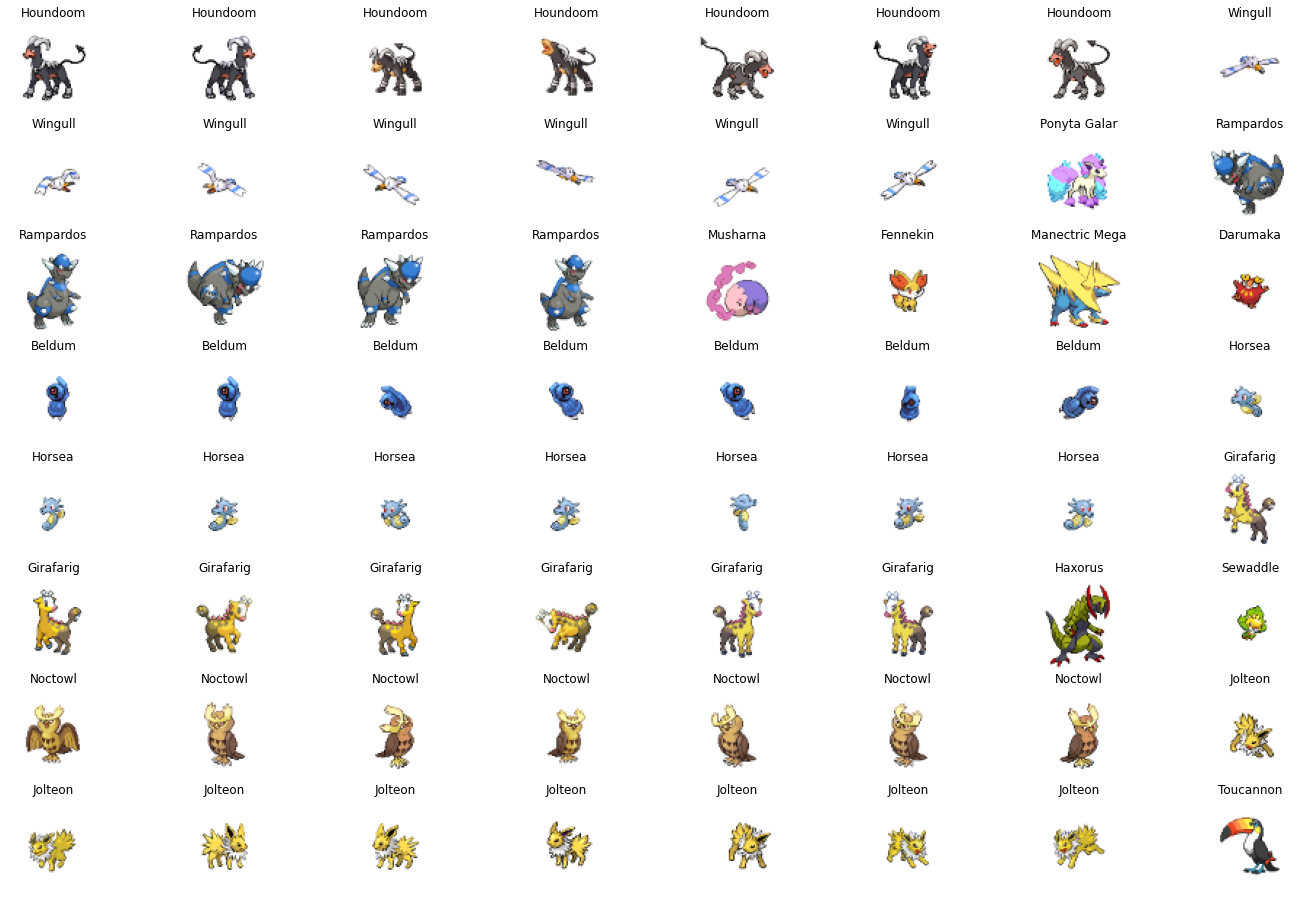

In [ ]:
make_images_grid(dataset.images,dataset.pkmn)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


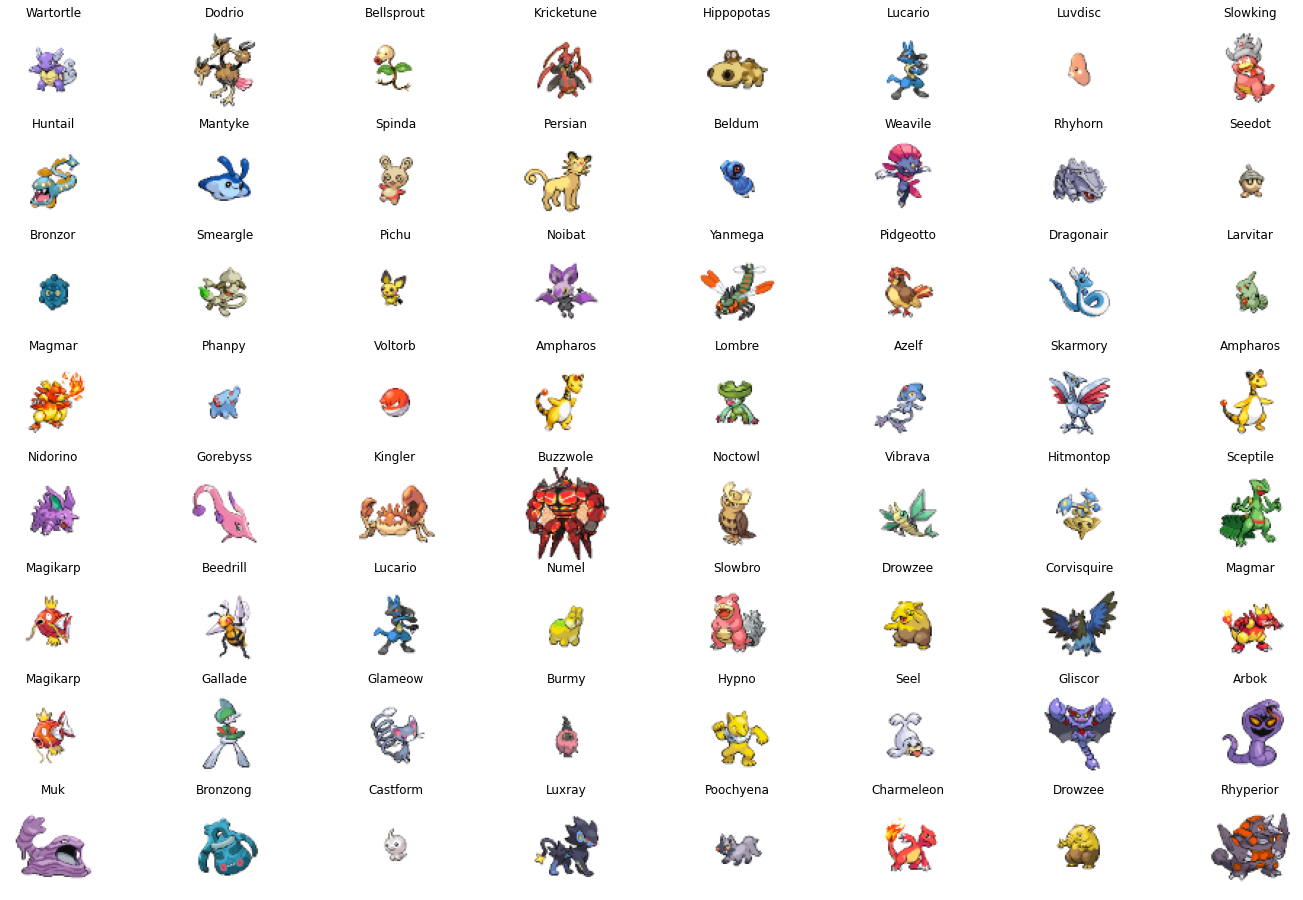

In [ ]:
dataloader_example = DataLoader(dataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=False )
example_images, example_labels = next(iter(dataloader_example))
make_images_grid(example_images, example_labels)


In [ ]:
#Generar modelo Generador de Pokemon Falsos

class Generator(nn.Module):
   def __init__ (self,seed_size):
     super(Generator, self).__init__()
     self.main=nn.Sequential(
     #Input seed_size x 1 x 1
     nn.ConvTranspose2d(seed_size, 32, kernel_size=4, padding=0, stride=1, bias=False), # Generación de vector aletorio 
     nn.BatchNorm2d(32),
     nn.ReLU(True),

     nn.ConvTranspose2d(32, 64, kernel_size=4, padding=1, stride=2, bias=False),
     nn.BatchNorm2d(64),
     nn.ReLU(True),

     nn.ConvTranspose2d(64, 128, kernel_size=4, padding=1, stride=2, bias=False),
     nn.BatchNorm2d(128),
     nn.ReLU(True),

     nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
     nn.BatchNorm2d(64),
     nn.ReLU(True),

     nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
     nn.Tanh()
     )

   def forward(self, input):
        return self.main(input)
      # Output: 3 x 64 x 64

In [ ]:
#show generator summary 
generator=Generator(100)
generator.to(device)
summary(generator, (100, 1, 1))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 32, 4, 4]          51,200
       BatchNorm2d-2             [-1, 32, 4, 4]              64
              ReLU-3             [-1, 32, 4, 4]               0
   ConvTranspose2d-4             [-1, 64, 8, 8]          32,768
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         131,072
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
seed_size=20
batch_size=64
generator=Generator(seed_size)
seed_batch = torch.randn(batch_size, seed_size, 1, 1)
fake_pokemon=generator(seed_batch)
row=2
col=2

In [ ]:
#Visualizar data
fake_pokemon_np=fake_pokemon.detach().numpy()
fr=fake_pokemon_np.reshape(64,64,3,batch_size)

In [ ]:
fake_pokemon.detach().size()

torch.Size([64, 3, 64, 64])

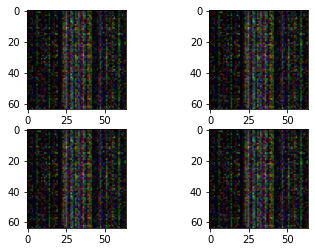

In [ ]:
fig, axs = plt.subplots(row,col,figsize=(row * 3, col * 2))
for n in range(batch_size):
    for i in range(row):
            for j in range(col):
              #Ver imagenes en rgb eliminar 1 y colocar :
              axs[i][j].imshow(fr[:, :, :, n])


In [ ]:
#Generar modelo Discriminador
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self). __init__()
    self.dis= nn.Sequential(
        #3 x 64 x 64
        nn.Conv2d(3, 256, kernel_size= 4,stride= 2,padding= 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        #64 x 32 x 32
        nn.Conv2d(256, 256, kernel_size= 4,stride=2,padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        #128x16x16
        nn.Conv2d(256, 128, kernel_size= 4,stride=2,padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        #128x8x8
        nn.Conv2d(128,128, kernel_size= 4,stride=2,padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(128, 1,kernel_size= 4, stride= 1, padding= 0, bias=False),
        nn.Sigmoid()
        )
  def forward(self, input):
        return self.dis(input)

In [ ]:
pip install torchviz

In [ ]:
#show Generator diagram 
summary(Generator(100).to(device), (100, 1, 1))
# show model with torchviz 
from torchviz import make_dot
x = torch.randn(1, 100, 1, 1).to(device)
y = Generator(100).to(device)(x)
g = make_dot(y, params=dict(Generator(100).named_parameters()))
g.view()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 32, 4, 4]          51,200
       BatchNorm2d-2             [-1, 32, 4, 4]              64
              ReLU-3             [-1, 32, 4, 4]               0
   ConvTranspose2d-4             [-1, 64, 8, 8]          32,768
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         131,072
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

'Digraph.gv.pdf'

In [ ]:
pip install pyCore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pycore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#show model in a image 
from torchsummary import summary
discriminator=Discriminator()
summary(discriminator, (3, 64, 64))
# show model with torchviz 
from torchviz import make_dot
make_dot(discriminator(fake_pokemon), params=dict(discriminator.named_parameters()))

RuntimeError: ignored

In [ ]:
torch.save(discriminator.state_dict(), 'discriminator.pth')

In [ ]:
from graphviz import Digraph
g = Digraph('G', filename='discriminator.gv')
g.attr(rankdir='LR', size='8,5')
g.node_attr.update(color='lightblue2', style='filled')
make_dot(discriminator(fake_pokemon), params=dict(discriminator.named_parameters())).render('discriminator', view=True)

'discriminator.pdf'

In [ ]:
discriminator=Discriminator()
learning_rate=0.000275
beta1=0.5
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.9))

print(discriminator.children)

<bound method Module.children of Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
   

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(128, 1, kernel_size

In [ ]:
#Parte Falsa
decision=discriminator(fake_pokemon)
print(decision)

tensor([[[[0.7290]]],


        [[[0.4747]]],


        [[[0.3698]]],


        [[[0.7052]]],


        [[[0.4298]]],


        [[[0.3183]]],


        [[[0.3336]]],


        [[[0.6050]]],


        [[[0.2659]]],


        [[[0.6101]]],


        [[[0.3192]]],


        [[[0.4725]]],


        [[[0.5182]]],


        [[[0.6928]]],


        [[[0.6164]]],


        [[[0.3993]]],


        [[[0.5671]]],


        [[[0.6225]]],


        [[[0.5193]]],


        [[[0.4327]]],


        [[[0.5961]]],


        [[[0.4521]]],


        [[[0.7155]]],


        [[[0.3528]]],


        [[[0.4638]]],


        [[[0.3781]]],


        [[[0.3337]]],


        [[[0.2313]]],


        [[[0.4394]]],


        [[[0.3293]]],


        [[[0.7628]]],


        [[[0.4824]]],


        [[[0.6607]]],


        [[[0.4534]]],


        [[[0.3738]]],


        [[[0.7841]]],


        [[[0.6928]]],


        [[[0.5666]]],


        [[[0.3807]]],


        [[[0.4871]]],


        [[[0.4284]]],


        [[[0.472

In [ ]:
#Parte Real
decision=discriminator(example_images)
print(decision)

tensor([[[[0.3821]]],


        [[[0.3826]]],


        [[[0.4546]]],


        [[[0.5497]]],


        [[[0.5906]]],


        [[[0.4880]]],


        [[[0.5337]]],


        [[[0.2815]]],


        [[[0.4200]]],


        [[[0.3548]]],


        [[[0.4254]]],


        [[[0.4520]]],


        [[[0.4329]]],


        [[[0.5017]]],


        [[[0.3952]]],


        [[[0.4677]]],


        [[[0.2936]]],


        [[[0.4914]]],


        [[[0.3731]]],


        [[[0.4891]]],


        [[[0.4168]]],


        [[[0.4989]]],


        [[[0.5344]]],


        [[[0.3741]]],


        [[[0.4791]]],


        [[[0.3682]]],


        [[[0.5140]]],


        [[[0.4134]]],


        [[[0.4891]]],


        [[[0.3494]]],


        [[[0.3820]]],


        [[[0.6554]]],


        [[[0.3940]]],


        [[[0.4917]]],


        [[[0.6432]]],


        [[[0.4469]]],


        [[[0.5964]]],


        [[[0.5911]]],


        [[[0.3773]]],


        [[[0.7807]]],


        [[[0.4174]]],


        [[[0.420

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
real_label=1
fake_label=0

In [ ]:
def trainNET(data,optimizerD,optimizerG,seed_size,batch_size=64):
   
    #Parte Real
    optimizerD.zero_grad()
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    #label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    label = torch.rand(real_cpu.size(0), device=device) * (0.1 - 0) + 0 
    
    real_predictions = discriminator(real_cpu).view(-1)
    real_loss = criterion(real_predictions, label)
    #real_loss.backward(retain_graph=True)
    real_score = real_predictions.mean().item() #obtiene calificación promedio
    #Parte falsa
    
    latent_batch = torch.randn(b_size, seed_size, 1, 1, device=device) #Definir si es mejor este tipo de ruido 
    fake_pokemon = generator(latent_batch)
    #label.fill_(fake_label)
    label= torch.rand(real_cpu.size(0), device=device) * (1 - 0.9) + 0.9 # etiquetas falsas 

    gen_predictions = discriminator(fake_pokemon.detach()).view(-1) # generacion de pokemon falso detach() se convierte en un arreglo algo que se puede procesar
    gen_loss= criterion(gen_predictions,label) #que tan se generó el pokemon 
    #gen_loss.backward() # obtiene la suma de todos los gradientes 
    total_loss = real_loss + gen_loss    # se suma la función de perdida de que tan bien se genero el pokemon y que tan bien está funcionando el discrimidor 
    total_loss.backward() #calcula los gradientes y
    optimizerD.step() #actualizamos el discriminador 

    #Entrenar Generador
    gen_score = torch.mean(gen_predictions).item() #
    
    #optimizerD.step()
    optimizerG.zero_grad() #Se estable a cero el optimizerG (del generador)
    latent_batch = torch.randn(b_size, seed_size, 1, 1, device=device) #Se genera vector aleatorio
    fake_pokemon = generator(latent_batch) #se genera la image 
    #label.fill_(real_label)
    label=torch.zeros(real_cpu.size(0), device=device) # hacemos las etiquetas ceros para los pokemons falsos 
    disc_predictions = discriminator(fake_pokemon).view(-1) # el discriminador hace la prediccion 
    loss = criterion(disc_predictions, label) # evalua que tan mal evalua el discriminador a las etiquetas
   
    loss.backward() #Valores de los gradientes 
    #generator_loss = disc_predictions.mean().item()
    optimizerG.step() # se actualiza 
    

    return total_loss.item(), real_score, gen_score, loss.item() 

In [ ]:
#show trainNET summary
from torchsummary import summary
summary(trainNET, (3, 64, 64))
# show model with torchviz
from torchviz import make_dot
make_dot(trainNET(example_images,optimizerD,optimizerG,seed_size), params=dict(trainNET.named_parameters()))
#sabe image as png


AttributeError: ignored

In [ ]:
#show diagram from trainNET
from graphviz import Digraph
g = Digraph('G', filename='trainNET.gv')
g.attr(rankdir='LR', size='8,5')
g.node_attr.update(color='lightblue2', style='filled')
# data 
#example_images
data=example_images
#optimizerD
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.9))
#optimizerG
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.9))   
make_dot(trainNET(data,optimizerD,optimizerG,seed_size,batch_size=64), params=dict(trainNET.named_parameters())).render('trainNET', view=True)


RuntimeError: ignored

In [ ]:
import torchvision.utils as vutils

In [ ]:
def trainGAN(num_epoch,iters,batch_size=64,seed_size=20,beta1=0.5,learning_rate=0.000275,idx=1,):
  torch.cuda.empty_cache()
   # Track losses and scores
  disc_losses = []
  disc_scores = []
  gen_losses = []
  gen_scores = []
  iters= iters


  print("Entrenando...")
  for epoch in range(num_epoch):  
   for i, data in enumerate(dataloader_example, 0):
     disc_loss, real_score, gen_score,gen_loss =trainNET(data,optimizerD,optimizerG,seed_size,batch_size)
   iters+=1
   disc_losses.append(disc_loss)
   disc_scores.append(real_score)
   gen_losses.append(gen_loss)
   gen_scores.append(gen_score)
   print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            iters, num_epoch, gen_loss, disc_loss, real_score, gen_score))
   if (iters % 10 == 0) or ((epoch == num_epoch/100 == 0)):
    save_model(CHECKPOINT_ROOT, generator, discriminator, iters)
    save_image(TEST_RESULTS_ROOT, generator, iters,(fixed_noise))

   
  return disc_losses, disc_scores, gen_losses, gen_scores

In [ ]:
criterion = nn.BCELoss() #Criterio entropia cruzada 
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.9)) #
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.9))

In [ ]:
#Pasamos la semilla del batch a GPU
seed_batch=to_device(seed_batch,device) 

In [ ]:
seed_size=20
batch_size=64
fixed_noise = torch.randn(batch_size, seed_size, 1, 1)
fixed_noise=fixed_noise.to(device)

In [ ]:
#Pasamos todo a un mismo entorno
to_device(generator,device)
to_device(discriminator,device)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(128, 1, kernel_size

In [ ]:
def save_model(save_dir, generator, discriminator, iters):
    iters_k = iters // 10
    G_path = os.path.join(save_dir,  f"{iters_k:05d}k-G.pth")
    D_path = os.path.join(save_dir,  f"{iters_k:05d}k-D.pth")

    torch.save(generator.state_dict(), G_path)
    torch.save(discriminator.state_dict(), D_path)

    print("Guardando Generador en ", G_path, "y Discriminador en", D_path)

In [ ]:
def save_image(save_dir, generator, iters, fixed_noise):
    iters_k = iters // 10

    generator.eval()
    with torch.no_grad():
        gen_images = generator(fixed_noise).detach().cpu()
    image = make_images_grid(gen_images,example_labels)

    img_path = os.path.join(save_dir, f"{iters_k:05d}k.png")
    image.save(img_path)
    print("Guardando imagen Generada en...", img_path)

In [ ]:
#show trainGAN as png 
def show_trainGAN(disc_losses, disc_scores, gen_losses, gen_scores):
    plt.figure(figsize=(10,5))
    plt.title("DCGAN perdida durante el entramiento")
    plt.plot(disc_losses,label="Discriminator")
    plt.plot(gen_losses,label="Generator")
    plt.xlabel("iteraciones")
    plt.ylabel("perdida")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.title("DCGAN aprendizaje durante el entramiento")
    plt.plot(disc_scores,label="Discriminador")
    plt.plot(gen_scores,label="Generador")
    plt.xlabel("iteraciones")
    plt.ylabel("Aprendizaje")
    plt.legend()
    plt.show()
# show
#disc_losses, disc_scores, gen_losses, gen_scores = trainGAN(100,0,64,20,0.5,0.000275,1)



In [ ]:
#Cargar GAN y correr con checkpoints no se recomienda >250 epocas de entrenamiento acumuladas, colapsa la generación de imagenes
#apartir de las 50-100 epocas
#disc_losses, disc_scores, gen_losses, gen_scores = trainGAN(50,1)
disc_losses, disc_scores, gen_losses, gen_scores = trainGAN(100,51) # 100 es para el numero de epocas totales 
#trainGAN(150,101)

Entrenando...


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [52/100], gen_loss: 3.2532, disc_loss: 0.4225, real_score: 0.0244, gen_score: 0.9792
Epoch [53/100], gen_loss: 2.8872, disc_loss: 0.7793, real_score: 0.4194, gen_score: 0.9654
Epoch [54/100], gen_loss: 2.7275, disc_loss: 0.7269, real_score: 0.1730, gen_score: 0.6801
Epoch [55/100], gen_loss: 3.0423, disc_loss: 0.4916, real_score: 0.1839, gen_score: 0.9318
Epoch [56/100], gen_loss: 4.1898, disc_loss: 0.6161, real_score: 0.1311, gen_score: 0.7314
Epoch [57/100], gen_loss: 4.4154, disc_loss: 0.7764, real_score: 0.0926, gen_score: 0.6133
Epoch [58/100], gen_loss: 3.0709, disc_loss: 0.7174, real_score: 0.2871, gen_score: 0.7957
Epoch [59/100], gen_loss: 5.5907, disc_loss: 0.8412, real_score: 0.1099, gen_score: 0.5535
Epoch [60/100], gen_loss: 2.5104, disc_loss: 2.0532, real_score: 0.8166, gen_score: 0.9896
Guardando Generador en  /content/drive/MyDrive/Pokemon/checkpoints/PokemonGANV5/00006k-G.pth y Discriminador en /content/drive/MyDrive/Pokemon/checkpoints/PokemonGANV5/00006k-D.pth


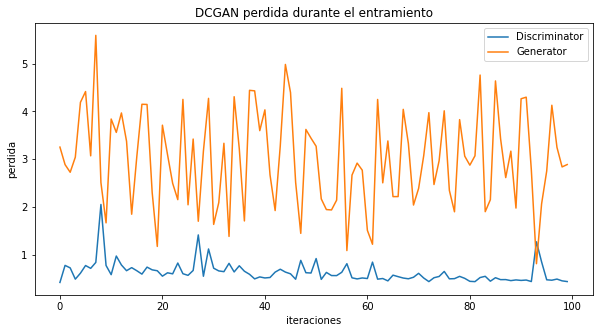

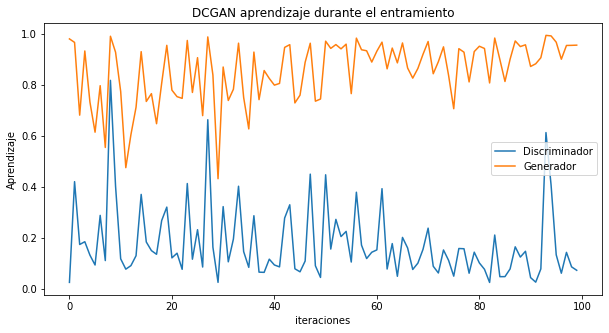

In [ ]:
show_trainGAN(disc_losses, disc_scores, gen_losses, gen_scores)

In [ ]:
from IPython.display import Image

AttributeError: ignored

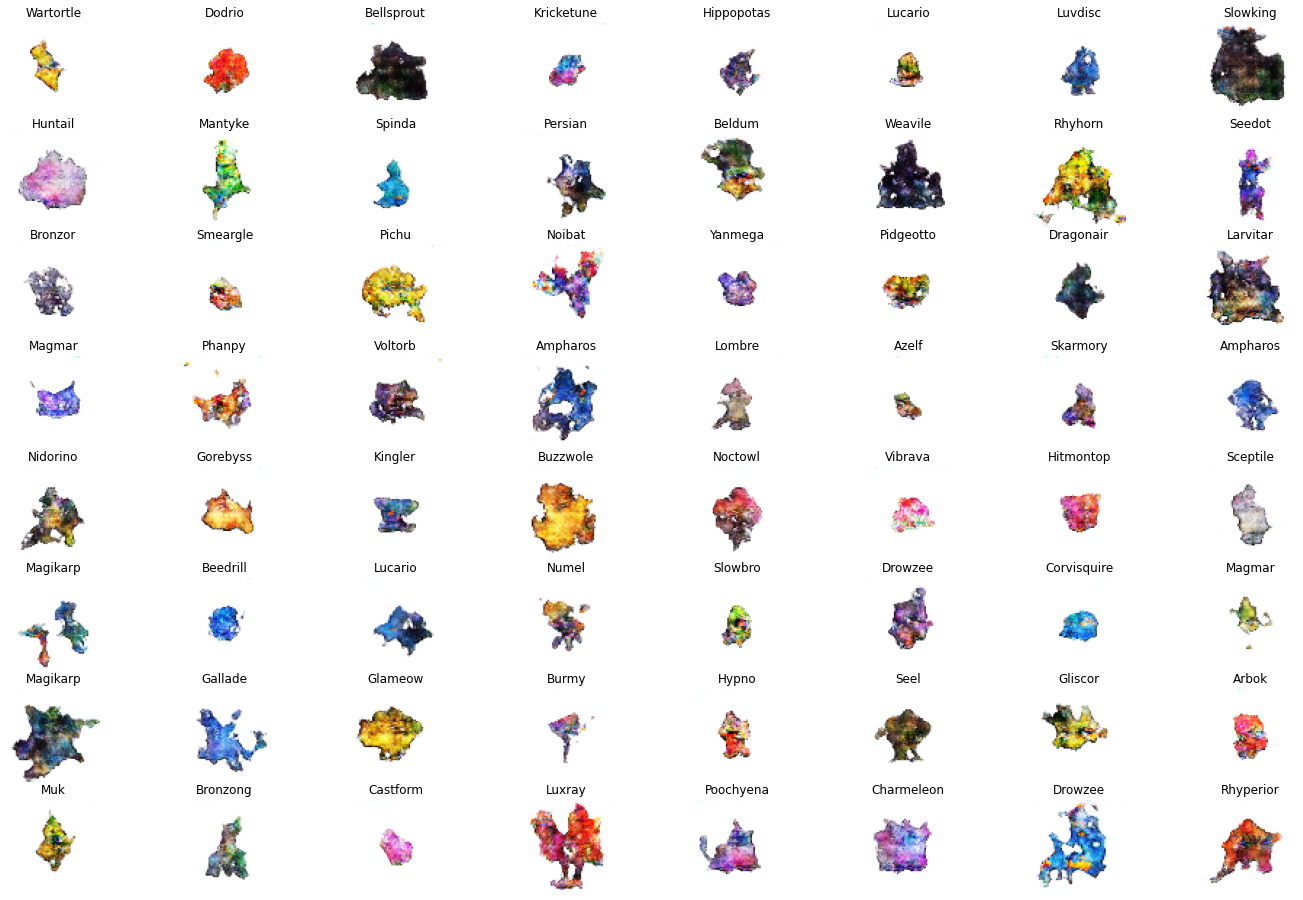

In [ ]:
with torch.no_grad():
        latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
        gen_images = generator(latent_batch).detach().cpu()
        generated_pokemon = make_images_grid(gen_images,example_labels)

In [ ]:
def load_model(save_dir, generator, discriminator, iters):
    iters_k = iters // 10
    G_path = os.path.join(save_dir,  f"{iters_k:05d}k-G.pth")
    D_path = os.path.join(save_dir,  f"{iters_k:05d}k-D.pth")

    generator.load_state_dict(torch.load(G_path))
    discriminator.load_state_dict(torch.load(D_path))
    
    print("Loaded generator from", G_path, "and discriminator from", D_path)

In [ ]:
load_model(CHECKPOINT_ROOT, generator, discriminator,140)

Loaded generator from /content/drive/MyDrive/Pokemon/checkpoints/PokemonGANV5/00014k-G.pth and discriminator from /content/drive/MyDrive/Pokemon/checkpoints/PokemonGANV5/00014k-D.pth


Falta Recuperar la imagen una vez procesada por el GPU

AttributeError: ignored

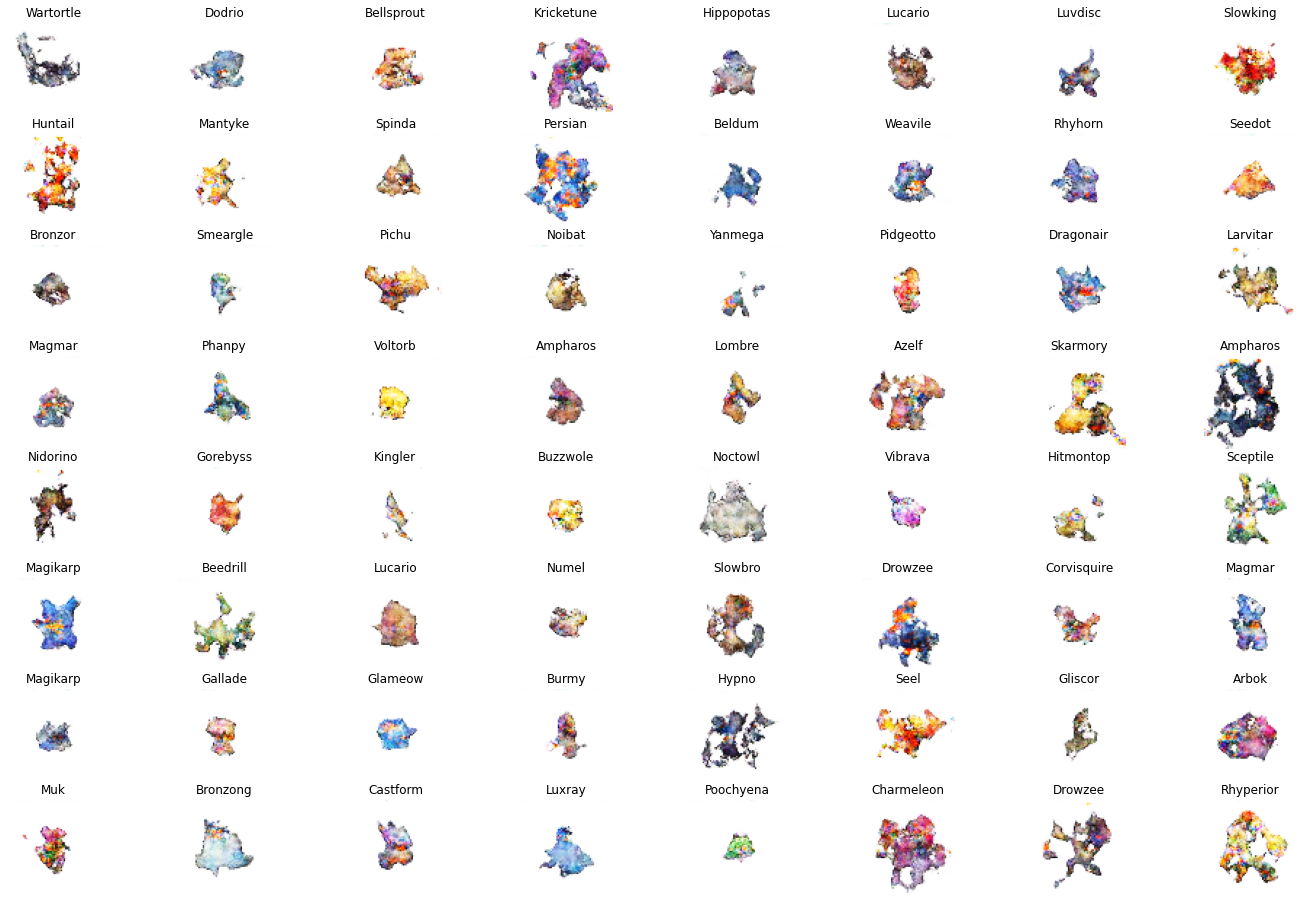

In [ ]:
latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
gen_images = generator(latent_batch).detach().cpu()
image = make_images_grid(gen_images,example_labels)
#fake_pokemon_np=fake_pokemon.cpu().detach().numpy()
#fr=fake_pokemon_np.reshape(64,64,3,batch_size)
# def save_image(save_dir, generator, iters, fixed_noise):
#     iters_k = iters // 10

#     generator.eval()
#     with torch.no_grad():
#         gen_images = generator(fixed_noise).detach().cpu()
#     image = make_images_grid(gen_images,example_labels)

#     img_path = os.path.join(save_dir, f"{iters_k:05d}k.png")
#     image.save(img_path)
#     print("Guardando imagen Generada en...", img_path)

In [ ]:
#fig
#plt.imshow(image)
plotear1(image)

NameError: ignored

In [ ]:
def plotear1(img):
    fig = plt.figure(figsize=(30,30))
    fig.add_subplot(1,1,1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title("imagen original")
    # fig.add_subplot(1,2,2)
    # plt.imshow(imgGray,cmap='gray')
    # plt.axis('off')
    # plt.title("imagen filtrada")
    # plt.show()

Ejemplo tras una epoca de entrenamiento en CPU, se me acabo de vuelta la GPU xD podemos observar como cambio el fondo a pixeles blancos y comienza a generar pixeles de colores por el centro va por buen camino

Bibliografia, les recomiendo checarla porque se utilizó

https://www.kaggle.com/datasets/yehongjiang/pokemon-sprites-images

https://github.com/rubyyhj/PokeTypeGAN/blob/main/PokeTypeGAN.ipynb

https://www.tensorflow.org/tutorials/generative/dcgan

https://github.com/jkleiber/PokeGAN/blob/master/PokeGAN.ipynb
